# Exploring results for a single experiment

In this notebook, we check the results for a single experiment. For RPE and RGE-EFR experiments, some cells may not execute due to inexistence of data .

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
import ipywidgets
%matplotlib notebook
import pickle
import os
import json
import pprint
from itertools import *
import scipy.stats
from tqdm import tqdm_notebook as tqdm
import matplotlib.lines

## Config
We load experiment data from a given result folder and check the configuration:

In [55]:
path = "results/Rge-Vae Armarrow 10L Kde 1518449180/"
with open(os.path.join(path, "config.json")) as f:
    config = json.load(f)
pprint.pprint(config)

{u'deformation': 0.0,
 u'distractor': False,
 u'embedding': u'vae',
 u'environment': u'armarrow',
 u'explo_ratio': 0.05,
 u'name': u'Rge-Vae Armarrow 10L Kde 1518449180',
 u'nb_bins_exploration_ratio': 10,
 u'nb_exploration_iterations': 5000,
 u'nb_period_callback': 10,
 u'nb_samples': 10000,
 u'nb_samples_divergence': 1000,
 u'nb_samples_manifold': 1000,
 u'nb_samples_mse': 100,
 u'nlatents': 10,
 u'noise': 0.0,
 u'outliers': 0.0,
 u'path': u'results/Rge-Vae Armarrow 10L Kde 1518449180',
 u'sampling': u'kde',
 u'test': False,
 u'verbose': False}


# Representation
First, let's plot a few figures concerning only the representation for sanity check.

### Training images
We plot the training images

<IPython.core.display.Javascript object>


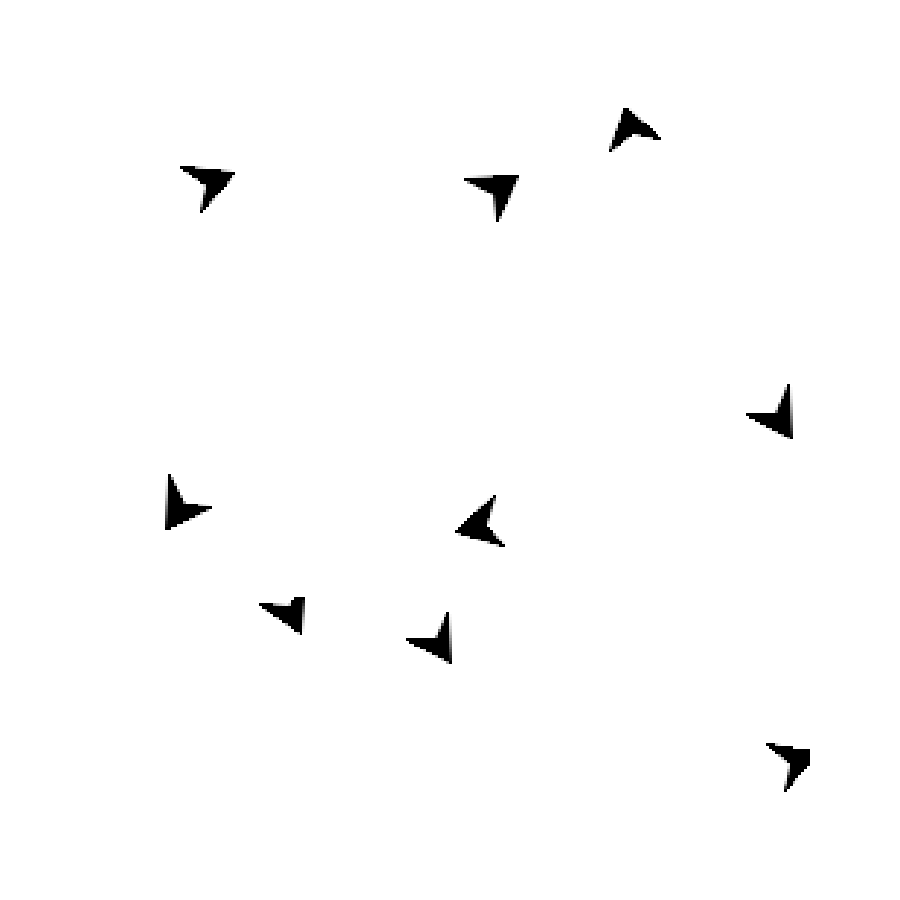

In [56]:
X = np.load(os.path.join(path, 'training_images.npy'))
fig, ax = plt.subplots(3,3, figsize=(9,9))
for i in range(9):
    ax[i%3, i/3].imshow(X[i])
    ax[i%3, i/3].axis("off")

### Training States
We plot the sampled states (location of object) that were used to generate the images, and estimate the latent distribution with kde.

<IPython.core.display.Javascript object>


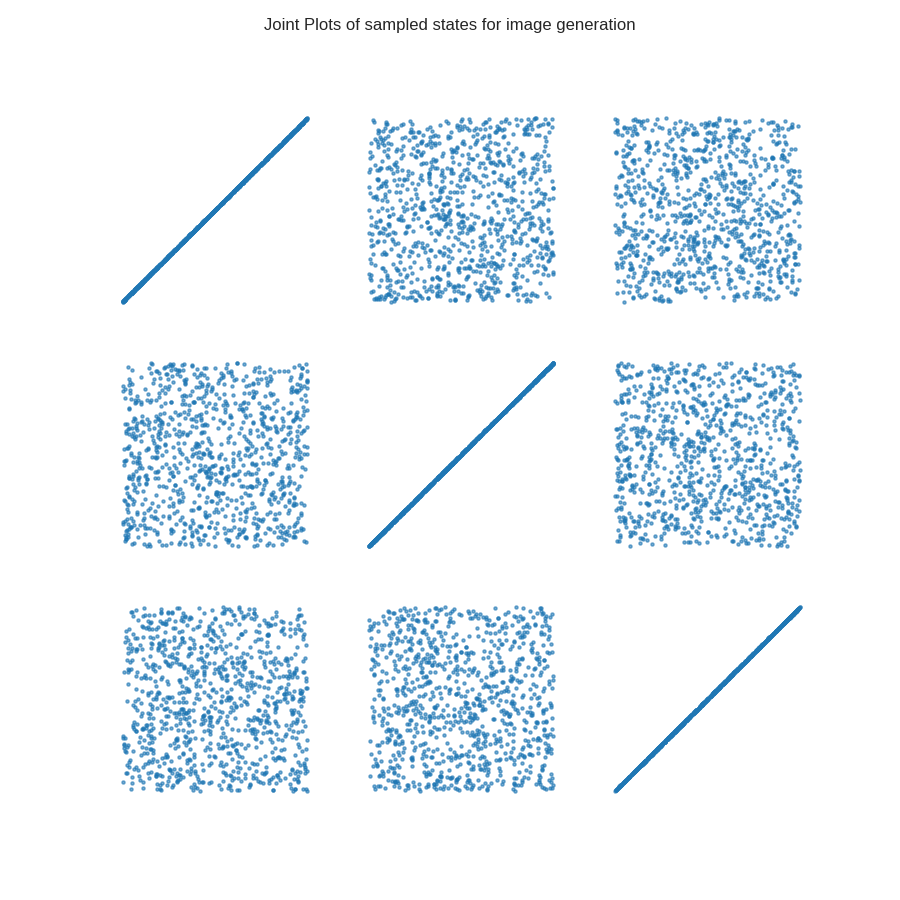

In [57]:
states = np.load(os.path.join(path, 'samples_states.npy'))
n_states=states.shape[-1]
fig, ax = plt.subplots(n_states,n_states, figsize=(9,9))
for i in range(n_states**2):
    ax[i%n_states, i/n_states].scatter(states[:,i%n_states], states[:,i/n_states], s=5., alpha=.6)
    ax[i%n_states, i/n_states].axis('off')
fig.suptitle("Joint Plots of sampled states for image generation");

### Latent projection of training set after training
We plot the projection of latents of the training samples on the 2 first axis, and on all couples of axis.

<IPython.core.display.Javascript object>


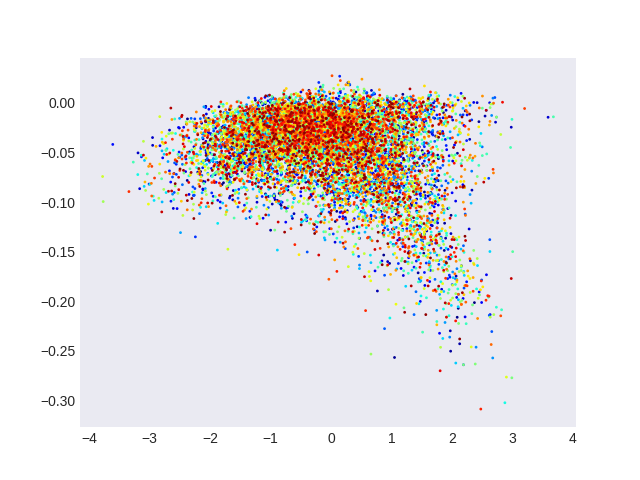

In [58]:
latents = np.load(os.path.join(path, 'training_latents.npy'))
plt.figure()
plt.scatter(latents[:,0], latents[:,1], s=1., cmap='jet', c = range(latents.shape[0]));

<IPython.core.display.Javascript object>


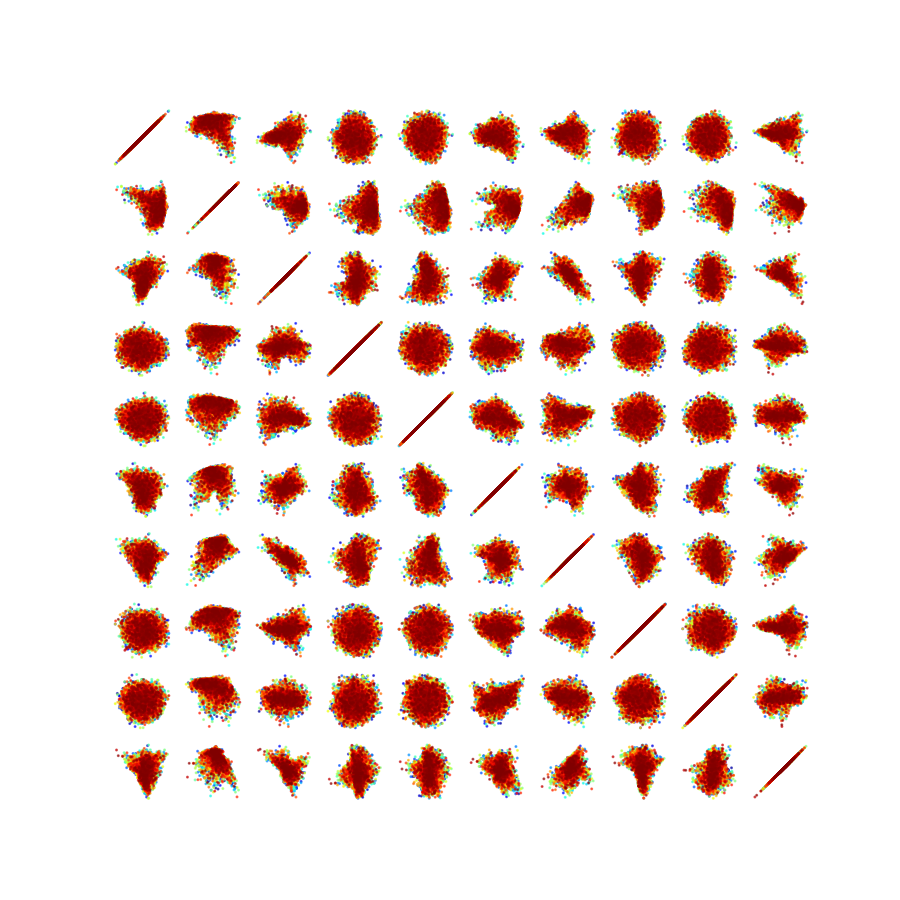

In [59]:
latents = np.load(os.path.join(path, 'training_latents.npy'))
n_latents=latents.shape[-1]
fig, ax = plt.subplots(n_latents,n_latents, figsize=(9,9))
for i in range(n_latents**2):
    ax[i%n_latents, i/n_latents].scatter(latents[:,i%n_latents], 
                                         latents[:,i/n_latents], 
                                         s=5., 
                                         c=range(latents.shape[0]),
                                         cmap='jet',
                                         marker='.',
                                         alpha=.6)
    
    ax[i%n_latents, i/n_latents].axis('off')

## Exploration Dynamics
We now check the dynamics of exploration produced during experiment.

### Locations Explored
We observe the evolution of achieved points through exploration iterations.

In [60]:
with open(os.path.join(path, "explored_states_history.pkl"), 'rb') as f:
    explored_states_history = pickle.load(f)
arm = scipy.misc.imread('test.png')

<IPython.core.display.Javascript object>


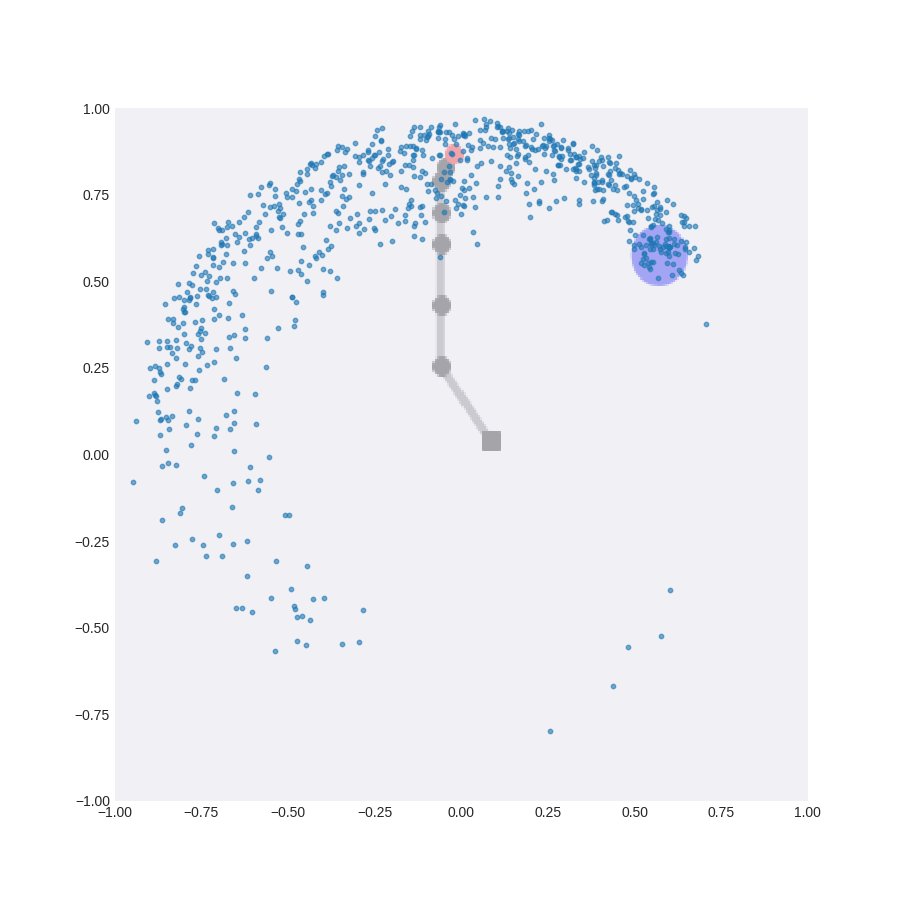

A Jupyter Widget

In [61]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(1, 1, 1)
scatt = ax.scatter(explored_states_history[498][:,0], 
                   explored_states_history[498][:,1],
                   cmap='jet', s=10., alpha=.6)
ax.imshow(arm, extent=[-1,1, -1, 1], alpha=.3)
def update(epoch):
    scatt.set_offsets(explored_states_history[epoch*10][:,0:2])
    fig.canvas.draw()
ipywidgets.interact(update, epoch=(0, 48));

### Evolution of KL-Coverage

We observe the evolution of the KL-Coverage and number of grasps through exploration iterations.

In [62]:
def sample_in_circle(nb_points):
    """
    This function allows to sample random points inside a circle using rejection sampling.
    """
    i = 0
    X = np.ndarray((nb_points, 2))
    while not i == nb_points:
        sample = np.random.uniform(-1, 1, 2)
        if np.linalg.norm(sample, ord=2) >1.:
            continue
        X[i] = sample
        i += 1
    return X

# We construct the histograms of achievable distribution
n_bins = 30
circ_samp = sample_in_circle(1000000)
hist_ab, _ = np.histogramdd(circ_samp, bins=n_bins, range=np.array([[-1]*2, [1]*2]).T)
hist_ab = hist_ab.astype(np.bool).astype(np.float)
hist_aa = np.tile(hist_ab.reshape(30,30,1), 30)

def kl_cov(X_s):
    n_samples, n_dim = X_s.shape
    histp , _ = np.histogramdd(X_s, bins=n_bins, range=np.array([[-1]*n_dim, [1]* n_dim]).T)
    if config['environment'] == 'armball':
        histq = hist_ab
    else:
        histq = hist_aa
    histq = histq.ravel()    
    histp = histp.ravel()
    return scipy.stats.entropy(histp, histq)

In [63]:
with open(os.path.join(path, "explored_states_history.pkl"), 'rb') as f:
    explored_states_history = pickle.load(f)

In [64]:
kls = np.zeros((49))
expl = np.zeros((49))
for i in tqdm(range(49)):   
    explored = explored_states_history[i*10]
    kls[i] = kl_cov(explored)
    if config['environment'] == 'armball':
        expl[i] = np.sum(np.linalg.norm(explored_states_history[i*10] - np.array([0.6, 0.6]), axis=1, ord=2) > 1e-3)
    else:
        expl[i] = np.sum(np.linalg.norm(explored_states_history[i*10] - np.array([0.6, 0.6, 0.6]), axis=1, ord=2) > 1e-3)

A Jupyter Widget

<IPython.core.display.Javascript object>


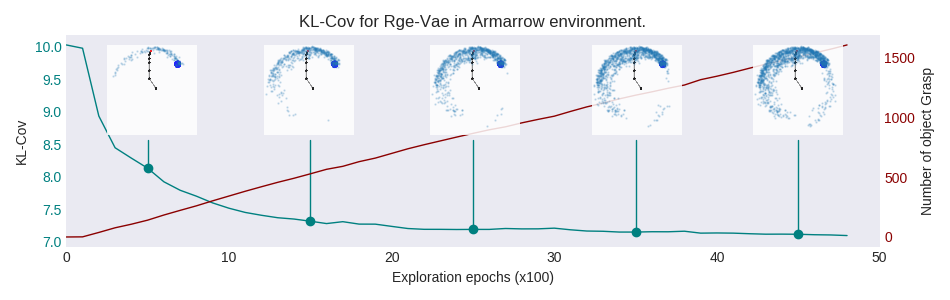

In [66]:
arm = scipy.misc.imread('test.png')
cmap='Blues'

fig = plt.figure(figsize=(9.5,3))
plt.title("KL-Cov for {} in {} environment.".format(config['name'].split(' ')[0], config['environment'].title()))

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(kls, linewidth=1., label="KL-Cov", color="teal")
ax1_2 = ax1.twinx()
ax1_2.plot(expl, linewidth=1., c='darkred', label="Number of object Grasp")
ax1_2.set_ylabel("Number of object Grasp")
ax1.set_xlim(0., 50.)
ax1.set_xlabel("Exploration epochs (x100)")
ax1.set_ylabel("KL-Cov")
hi=min(kls)+(max(kls)-min(kls))/2
ax1.add_line(matplotlib.lines.Line2D([5,5],   [kls[5]+.05, hi], linewidth=1, color='teal'))
ax1.add_line(matplotlib.lines.Line2D([15,15], [kls[15]+.05, hi], linewidth=1, color='teal'))
ax1.add_line(matplotlib.lines.Line2D([25,25], [kls[25]+.05, hi], linewidth=1, color='teal'))
ax1.add_line(matplotlib.lines.Line2D([35,35], [kls[35]+.05, hi], linewidth=1, color='teal'))
ax1.add_line(matplotlib.lines.Line2D([45,45], [kls[45]+.05, hi], linewidth=1, color='teal'))
points = [5,15,25,35,45]
ax1.scatter(points, kls[points], color="teal")
ax1_2.tick_params(axis='y', colors='darkred')
ax1.tick_params(axis='y', colors='teal')

ax = fig.add_axes([0.01, 0.55, .3, .3])
ax.imshow(arm, extent=[-1,1, -1, 1], alpha=.85)
ax.scatter(explored_states_history[50][:,0], explored_states_history[50][:,1], s=.5, alpha=.2)
ax.axis("off")

ax = fig.add_axes([0.175, 0.55, .3, .3])
ax.imshow(arm, extent=[-1,1, -1, 1], alpha=.85)
ax.scatter(explored_states_history[150][:,0], explored_states_history[150][:,1], s=.5, alpha=.2)
ax.axis("off")

ax = fig.add_axes([0.35, 0.55, .3, .3])
ax.imshow(arm, extent=[-1,1, -1, 1], alpha=.85)
ax.scatter(explored_states_history[250][:,0], explored_states_history[250][:,1], s=.5, alpha=.2)
ax.axis("off")

ax = fig.add_axes([0.52, 0.55, .3, .3])
ax.imshow(arm, extent=[-1,1, -1, 1], alpha=.85)
ax.scatter(explored_states_history[350][:,0], explored_states_history[350][:,1], s=.5, alpha=.2)
ax.axis("off")

ax = fig.add_axes([0.69, 0.55, .3, .3])
ax.imshow(arm, extent=[-1,1, -1, 1], alpha=.85)
ax.scatter(explored_states_history[450][:,0], explored_states_history[450][:,1], s=.5, alpha=.2)
ax.axis("off");

plt.tight_layout()